## Imports and Code Setup

In [4]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import interpolate
from tqdm import tqdm
import time
import RPi.GPIO as GPIO
import time

GPIO.setmode(GPIO.BCM)
matplotlib.rcParams['figure.figsize'] = [12, 5]



## Earthquake Class Definition

In [28]:
#data importer class
#expects certain input format I should look that up

class hardware_safety():
    def __init__(self):
        
        self.init_gpio()
        
    def init_gpio(self):
        GPIO.setmode(GPIO.BCM)
        self.control_pins = [17, 27]
        for pin in self.control_pins:
            GPIO.setup(pin, GPIO.OUT)
            GPIO.output(pin, 0)
        self.input_pins = [19, 26]
        for pin in self.input_pins:
            GPIO.setup(pin, GPIO.IN, pull_up_down=GPIO.PUD_UP)
            
    def zero(self):
        while GPIO.input(26):
            self.step(-1)
            time.sleep(0.001)
        pass
    
    def step(self, direction):
        seq1 = [
            [1,0],
            [0,0],
        ]
        seq2 = [
            [1,1],
            [0,1],
        ]
        
        if direction == 1:
            for halfstep in range(2):
                GPIO.output(self.control_pins, seq1[halfstep])
        elif direction == -1: #-1
            for halfstep in range(2):
                GPIO.output(self.control_pins, seq2[halfstep])
                
    def get_limit_switch_states(self):
        #returns right switch, left switch states
        return GPIO.input(26), GPIO.input(19)
    
    def load_trajectory(self):
        self.earthquake = earthquake_reader('earthquake.csv', percentEarthquake = 1, dt = 0.001, step_size = 2*np.pi/180/25, amplitude_scaling = 2)
        self.earthquake.fit_spline()
        self.earthquake.interpolate_earthquake(time_stretch = 50)
        
        #earthquake.sine(0.2)
        self.earthquake.calculate_steps()

        
    def run_trajectory(self):

        dt = self.earthquake.dt/30
        A = self.earthquake.relativeSteps
        a = np.zeros(len(A))

        for i in range(len(A)):
            
            if not GPIO.input(19) or not GPIO.input(26):
                print('Hit a limit switch, should not have')
                break
                
            start = time.time()
            val = A[i]
            self.step(val)
            while(time.time()-start<dt):
                wait = 1
            a[i] = (((time.time()-start)-dt)**2)**0.5

class earthquake_reader():
    def __init__(self, csv_file_name, percentEarthquake, dt, step_size, amplitude_scaling):
        
        self.dt = dt
        self.step_size = step_size
        self.amplitude_scaling = amplitude_scaling
        
        #load file
        self.earthquake_data = []
        with open(csv_file_name, 'r') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in spamreader:
                self.earthquake_data.append(row)
                
        #strip amplitude data
        amplitude = [value[1] for value in self.earthquake_data[9:]]
        
        self.amplitude = np.array(amplitude).astype('float')
        self.amplitude = self.amplitude[:int(percentEarthquake*self.amplitude.shape[0])]
        self.time = np.arange(0,self.dt*self.amplitude.shape[0],self.dt)
        
        self.dt_interpolated = None
        self.amplitude_interpolated = None
        self.time_interpolated = None
        
    def sine(self, frequency):
        amplitude = np.max(np.abs(self.amplitude_interpolated))
        for i in range(self.amplitude_interpolated.shape[0]):
            self.amplitude_interpolated[i] = np.sin(i*frequency*2*np.pi*self.dt)*amplitude
        
    def fit_spline(self):
        self.f = interpolate.interp1d(self.time, self.amplitude) #, kind='cubic')

    def interpolate_earthquake(self, time_stretch):
        self.dt_interpolated = self.dt / time_stretch
        self.time_interpolated = np.arange(0, self.time[-1], self.dt_interpolated)
        self.amplitude_interpolated = self.f(self.time_interpolated)
        self.time_interpolated *= time_stretch
        
    def calculate_steps(self):
        self.amplitude_interpolated_scaled = self.amplitude_interpolated * self.amplitude_scaling
        self.da = self.amplitude_interpolated_scaled[1:]-self.amplitude_interpolated_scaled[:-1]
        
        if np.abs(np.max(self.da)) > 1:
            print('Scaling constant or control frequency is too low')
            
            
        self.relativeSteps = np.zeros(self.amplitude_interpolated_scaled.shape[0])
        relativeStepsSum = 0
        for i in tqdm(range(self.amplitude_interpolated_scaled.shape[0])):
            if i > 0:
                relativeStepsSum += self.relativeSteps[i-1]
            if self.amplitude_interpolated_scaled[i] - relativeStepsSum >= 1:
                self.relativeSteps[i] = 1
            elif self.amplitude_interpolated_scaled[i] - relativeStepsSum <= -1:
                self.relativeSteps[i] = -1


In [32]:
robot = hardware_safety()
robot.zero()

In [33]:

steps = 0
r, l = robot.get_limit_switch_states()
while l:
    r, l = robot.get_limit_switch_states()
    print('right: {} left: {}'.format(r,l))
    robot.step(1)
    time.sleep(0.01)
    steps += 1
    
print(steps)

right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left:

right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left: 1
right: 1 left:

In [18]:
robot.load_trajectory()
robot.run_trajectory()

  3%|▎         | 3205/119950 [00:00<00:03, 32041.63it/s]

Scaling constant or control frequency is too low


100%|██████████| 119950/119950 [00:02<00:00, 58065.92it/s]


In [14]:
for _ in range(50):
    if GPIO.input(19):
        print('Input was HIGH')
    else:
        print('Input was LOW')
    time.sleep(0.1)

Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was LOW
Input was LOW
Input was LOW
Input was LOW
Input was LOW
Input was LOW
Input was LOW
Input was LOW
Input was LOW
Input was LOW
Input was LOW
Input was LOW
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH
Input was HIGH


## Load Earthquake

In [3]:
#loads earthquake and proccesses
earthquake = earthquake_reader('earthquake.csv', percentEarthquake = 1, dt = 0.001, step_size = 2*np.pi/180/25, amplitude_scaling = 2)
earthquake.fit_spline()
earthquake.interpolate_earthquake(time_stretch = 50)

#overwrites earthquake and uses a sine wave (function of period in seconds) ?maybe?
earthquake.sine(0.2)

#converts the positions to motor steps
earthquake.calculate_steps()


  5%|▍         | 5553/119950 [00:00<00:02, 55525.55it/s]

Scaling constant or control frequency is too low


100%|██████████| 119950/119950 [00:02<00:00, 59280.95it/s]


In [4]:
import RPi.GPIO as GPIO
import time
GPIO.setmode(GPIO.BCM)
control_pins = [17, 27]

dt = earthquake.dt/30

for pin in control_pins:
    GPIO.setup(pin, GPIO.OUT)
    GPIO.output(pin, 0)

seq1 = [
    [1,0],
    [0,0],
]

seq2 = [
    [1,1],
    [0,1],
]

A = earthquake.relativeSteps#np.hstack([np.ones(2000), np.ones(2000)*-1, np.ones(2000), np.ones(2000)*-1])
#A = yDelta

a = np.zeros(len(A))

for i in range(len(A)):
    start = time.time()
        
    val = A[i]
    
    if val == 1:
        for halfstep in range(2):
            GPIO.output(control_pins, seq1[halfstep])
    if val == -1:
        for halfstep in range(2):
            GPIO.output(control_pins, seq2[halfstep])
                
    while(time.time()-start<dt):
        wait = 1
        
    a[i] = (((time.time()-start)-dt)**2)**0.5

print(dt)
print(np.mean(a))
print(np.var(a))

GPIO.cleanup()

3.3333333333333335e-05
5.469887704174766e-06
4.709156172468614e-11


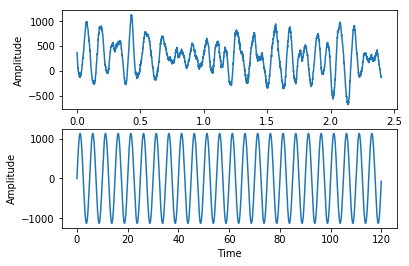

In [15]:

#print(earthquake.amplitude)
#print(earthquake.time)

plt.subplot(2,1,1)
plt.plot(earthquake.time, earthquake.amplitude)
plt.xlabel('Time')
plt.ylabel('Amplitude')



plt.subplot(2,1,2)
plt.plot(earthquake.time_interpolated, earthquake.amplitude_interpolated)
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.show()

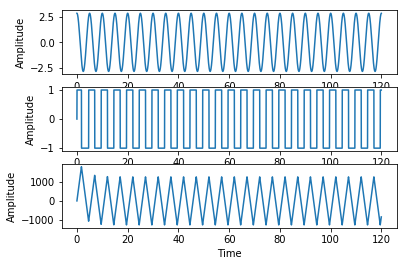

Number of time steps: 119950


In [12]:
plt.figure()
plt.subplot(3,1,1)
plt.plot(earthquake.time_interpolated[:-1], earthquake.da)
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.subplot(3,1,2)
plt.plot(earthquake.time_interpolated, earthquake.relativeSteps)
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.subplot(3,1,3)
plt.plot(earthquake.time_interpolated, np.cumsum(earthquake.relativeSteps))
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.show()

print('Number of time steps: {}'.format(earthquake.relativeSteps.shape[0]))

In [32]:
dt

1e-05

use this to send the signals to the arduino to execute.


can we send the whole frame to the arduino in one go???


https://github.com/interactive-matter/MinProtocol

https://github.com/pootle/pisteppers

https://www.pjrc.com/store/teensy36.html

Try direct serial, then pistepper, then finally an exsternal micro

## Plot the loaded earthquake